# 顔画像を近似する劣決定連立方程式のPythonによる実装

連立方程式
$
A \boldsymbol{x} = \boldsymbol{b}
$
を解くPythonの実装を行う．

ただし，$A$の各列を画像にする．
つまり，画像データセット中の複数の学習画像$A$を用いて，
対象となるテスト画像$\boldsymbol{b}$を近似する問題を扱う．
求めるベクトル$\boldsymbol{x}$は，各学習画像に対する係数となる．


# 顔画像データセットの準備

In [3]:
# load modules

import numpy as np

import skimage.data
from skimage.transform import resize

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
plt.gray();

import sklearn
from sklearn.datasets import fetch_olivetti_faces


<Figure size 432x288 with 0 Axes>

In [4]:
# check versions

print("sklearn version :", sklearn.__version__, " >= 0.18.0")
print("skimage version :", skimage.__version__, " >= 0.12.0")
print("numpy version :", np.__version__, " >= 0.12.0")
print("matplotlib version:", matplotlib.__version__, ">= 2.0.0")

sklearn version : 0.22.2.post1  >= 0.18.0
skimage version : 0.16.2  >= 0.12.0
numpy version : 1.19.5  >= 0.12.0
matplotlib version: 3.2.2 >= 2.0.0


## 顔画像データセットのダウンロード

ここではsklearnのデータセットとして準備されているOlivetti facesデータセットを用いる．
詳しくは[sklearnのマニュアル](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html)を参照．

このデータセットには400枚の顔画像があり，それぞれが4096次元のベクトルである（64x64画像を表す）．

In [5]:
# load the face dataset

dataset = fetch_olivetti_faces(shuffle=False)
faces = dataset.data

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


これを，16x16画素にリサイズする．

In [6]:
faces_new = []
for f in faces:
    faces_new.append(resize(f.reshape(64, 64), (16, 16)))
faces = np.array(faces_new).reshape(400, -1)

このデータセットには400枚の顔画像があり，それぞれが256次元のベクトルである（16x16画像を表す）．

In [7]:
# faces has images as its row vectors

nsamples, dim = faces.shape
print("there are", nsamples, "samples of dimension", dim)

there are 400 samples of dimension 256


In [8]:
# see the inside of faces

faces

array([[0.43751124, 0.63092244, 0.6904305 , ..., 0.62004244, 0.48225194,
        0.16752663],
       [0.54309505, 0.67608166, 0.7076891 , ..., 0.13731068, 0.14535204,
        0.14694443],
       [0.44110247, 0.654829  , 0.7019388 , ..., 0.3385072 , 0.14038894,
        0.14517565],
       ...,
       [0.5760132 , 0.6549873 , 0.7282579 , ..., 0.1860121 , 0.16300893,
        0.16916682],
       [0.21484843, 0.29171857, 0.56469804, ..., 0.56850076, 0.46137553,
        0.536497  ],
       [0.37481683, 0.47245568, 0.6960255 , ..., 0.38089237, 0.31750607,
        0.34761629]], dtype=float32)

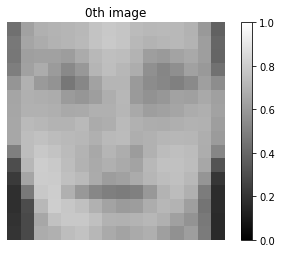

In [9]:
# show 0-th image with colorbar (pixel values range from 0 to 1)

# reshape(16, 16) converts a vector into a 64x64 image 
imshow(faces[0].reshape(16, 16), vmin=0, vmax=1) # set vmin=0 and vmax=1 to display value 0 to be black, and 1 white (otherwise min value is black and max value is white)

plt.colorbar() # show colorbar
plt.axis('off') # turn off border ticks
plt.title("0th image"); # set title

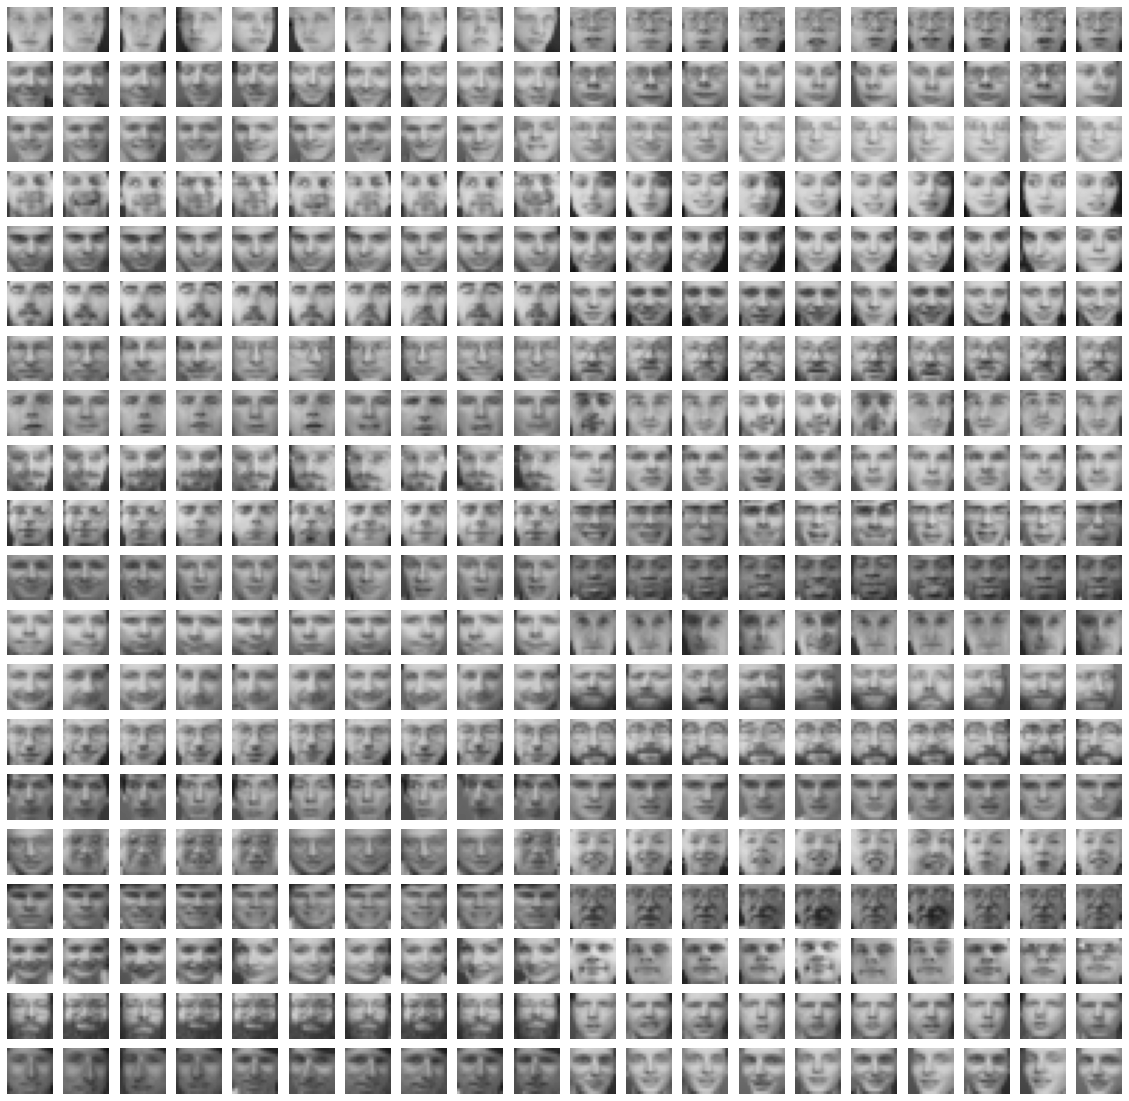

In [10]:
# show all 400 images. takes time, wait for a while....

plt.figure(figsize=(20, 20))
for i, p in enumerate(faces):
    plt.subplot(20, 20, i + 1)
    
    plt.imshow(faces[i].reshape(16, 16), vmin=0, vmax=1)
    
    plt.axis('off')

# 行列$A$の定義


データセットの各学習画像をベクトル$\boldsymbol{x}_i$とみなす．
各画像は2次元配列だが，1次元配列にreshapeする（Olivetti facesデータセットの場合にはすでに各画像が1次元配列になっている）．
学習画像として最初の300枚を用いることにする．


In [11]:
A = faces[:300].transpose()

`A`の各列は4096次元のベクトルである．

In [12]:
A.shape

(256, 300)

テスト画像であるベクトル$\boldsymbol{b}$としては3401〜400枚目のどれかを用いる．

In [13]:
b = faces[301] # 例えば301枚目

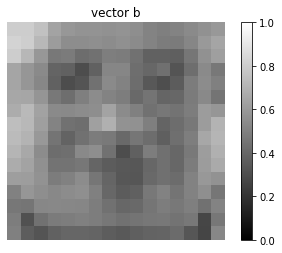

In [14]:
imshow(b.reshape(16, 16), vmin=0, vmax=1)

plt.colorbar()
plt.axis('off')
plt.title("vector b");

# 劣決定の連立方程式を解く

$A$は正方行列ではないため，一般化逆行列を用いて$x$を求める．

In [15]:
# x = A^T (A A^T)^{-1} b
x_solution = A.T @ np.linalg.inv(A @ A.T) @ b

なお，通常の実装上で逆行列を用いてはならない（逆行列が存在しないかもしれないし，存在しても条件数が悪いかもしれない．また逆行列の計算コストが大きい）．

In [16]:
print('|A^T A| = ', np.linalg.det(A.T @ A))
print('|A A^T| = ', np.linalg.det(A @ A.T))
print('rank(A) = ', np.linalg.matrix_rank(A))
print('rank(A A^T)', np.linalg.matrix_rank(A @ A.T), ' <= rank(A)rank(A^T)')
print('rank(A^T A)', np.linalg.matrix_rank(A.T @ A), ' <= rank(A)rank(A^T)')
# 0かどうかのしきい値tolを変更してみる
print('rank(A A^T)', np.linalg.matrix_rank(A @ A.T, tol=0.1), ' <= rank(A)rank(A^T)')
print('rank(A^T A)', np.linalg.matrix_rank(A.T @ A, tol=0.1), ' <= rank(A)rank(A^T)')

|A^T A| =  0.0
|A A^T| =  0.0
rank(A) =  256
rank(A A^T) 60  <= rank(A)rank(A^T)
rank(A^T A) 55  <= rank(A)rank(A^T)
rank(A A^T) 124  <= rank(A)rank(A^T)
rank(A^T A) 124  <= rank(A)rank(A^T)


この場合は，np.linalg.invは値を返すが，逆行列になっていない．

In [17]:
print((A @ A.T) @ np.linalg.inv(A @ A.T))
print(np.linalg.norm((A @ A.T) @ np.linalg.inv(A @ A.T) - np.eye(A.shape[0])))

[[ 0.921875 -0.03125   0.125    ... -0.125     0.078125  0.      ]
 [-0.078125  1.0625    0.4375   ...  0.       -0.03125  -0.03125 ]
 [ 0.       -0.125     1.375    ...  0.        0.0625    0.0625  ]
 ...
 [ 0.015625  0.21875  -0.25     ...  0.90625  -0.046875 -0.046875]
 [-0.046875 -0.0625   -0.03125  ...  0.046875  1.015625  0.015625]
 [ 0.03125  -0.03125   0.       ... -0.03125  -0.046875  1.0625  ]]
46.94519863342382


In [18]:
print((A.T @ A) @ np.linalg.inv(A.T @ A))
print(np.linalg.norm((A.T @ A) @ np.linalg.inv(A.T @ A) - np.eye(A.shape[1])))

[[ 9.84375000e-01 -2.34375000e-02 -3.12500000e-02 ... -1.14065953e-01
  -1.52995195e-02 -1.46525472e-01]
 [-7.81250000e-02  9.64843750e-01 -3.12500000e-02 ...  3.29389960e-01
   5.11510432e-01  1.55314747e-02]
 [-4.68750000e-02 -3.12500000e-02  8.43750000e-01 ...  9.70378667e-02
  -1.10205099e-01  4.20622140e-01]
 ...
 [ 5.82330860e-03  1.46395462e-02 -2.44268216e-02 ...  1.24433088e+00
   2.24420846e-01  1.26733273e-01]
 [ 5.86659014e-02  7.42682256e-04 -8.95561129e-02 ...  2.76842304e-02
   8.16829741e-01  1.64831392e-02]
 [-7.92918075e-03 -3.47434878e-02  4.87733036e-02 ... -1.97927549e-01
  -1.13208406e-03  9.66755152e-01]]
26.076187050372777


そのかわりに，`np.linalg.lstsq`を用いる．これは`Ax=b`を数値的に安定かつ効率的（高速に）解くものであり，`lstsq(A, b)`とすると`x`が得られる．`A`が正方で逆行列を持つ場合には通常の解を，優決定の場合は最小二乗解を，劣決定の場合には最小ノルム解を返す．

In [19]:
x_solution_np = np.linalg.lstsq(A, b, rcond=None)[0]

確認すると2つの解は異なることがわかる

In [20]:
np.linalg.norm(x_solution - x_solution_np)

13.599389

lstsqの最小ノルム解の方がノルムが小さいことがわかる．つまり逆行列で求めた方は正しくない（行列式が0なので正しく計算されていない）

In [21]:
np.linalg.norm(x_solution), np.linalg.norm(x_solution_np)

(14.698626, 4.383835)

lstsqの解はAx=bを満たしているが，逆行列を用いた式のほうは満たしていないことがわかる

In [22]:
np.linalg.norm(A @ x_solution - b), np.linalg.norm(A @ x_solution_np - b) 

(3.470122, 2.8178565e-06)

ではAのSVDを計算する．

In [23]:
U, W, Vtranspose = np.linalg.svd(A)
U.shape, W.shape, Vtranspose.shape

((256, 256), (256,), (300, 300))

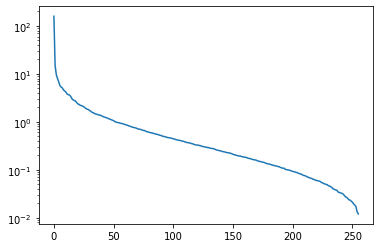

In [24]:
# 特異値の確認
plt.plot(W)
plt.yscale('log')

In [25]:
# A = U W V^Tを確認
np.linalg.norm(A - (U @ np.diag(W) @ Vtranspose[:len(W)]))

6.434954e-05

SVDによる一般化逆行列$A^+$を求める．ここではWの要素に0がないので，Wの逆行列の対角要素は単純に特異値の逆数からなる対角行列．またVは固有値に対応する列を抜き出して使う

In [26]:
Winv = np.zeros(len(W))
for i, w in enumerate(W):
    if w > np.finfo(W.dtype).eps:
        Winv[i] = 1 / w  # 機械精度より大きいなら逆数
    else:
        Winv[i] = 0.0

Apinv = Vtranspose[:len(W)].T @ np.diag(Winv) @ U.T
Apinv.shape

(300, 256)

一般化逆行列による最小ノルム解は次式で計算できる

In [27]:
x_solution_svd = Apinv @ b

ノルムを計算すると，np.linalg.lstsqと同じノルムを持つ

In [28]:
np.linalg.norm(x_solution), np.linalg.norm(x_solution_np), np.linalg.norm(x_solution_svd)

(14.698626, 4.383835, 4.38383372601978)

実際に2つの解は同じものである．

In [29]:
np.linalg.norm(x_solution_svd - x_solution_np)

3.08702965007648e-06

求めた係数ベクトル$x$を用いて$Ax$を計算し，画像として表示して，これが$b$とどれだけ似ているのかを確認する．

In [30]:
x = x_solution_np

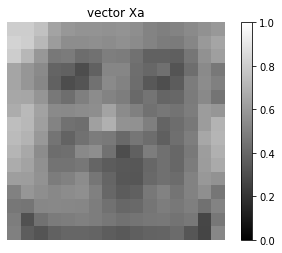

In [31]:
imshow((A @ x).reshape(16, 16), vmin=0, vmax=1)

plt.colorbar()
plt.axis('off')
plt.title("vector Xa");

劣決定なので，厳密に一致する

In [32]:
rmse = np.linalg.norm(A @ x - b) / b.shape[0]
print("RMSE: ", rmse)

RMSE:  1.1007251998762513e-08


係数ベクトル$x$の要素の内，大きい方から10個の要素の値と，それに対応する学習画像を表示する．これらは画像$b$を再構成する時に最も寄与が大きい．

In [33]:
rank = np.argsort(x)[::-1] # sort in decending order

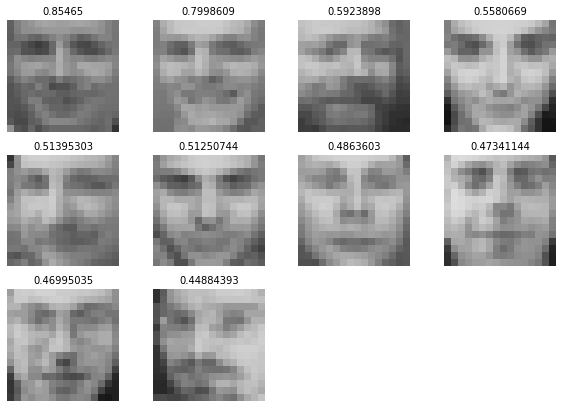

In [34]:
plt.figure(figsize=(10, 7))

for i, top_rank in enumerate(rank[:10]):
    plt.subplot(3, 4, i + 1)
    
    plt.imshow(A[:, top_rank].reshape(16, 16), vmin=0, vmax=1)
    plt.title(x[top_rank], fontsize=10)
    plt.axis('off')

# リッジ回帰

リッジ回帰の解を計算する．このとき$\lambda$の値を変えてみる変えてみる


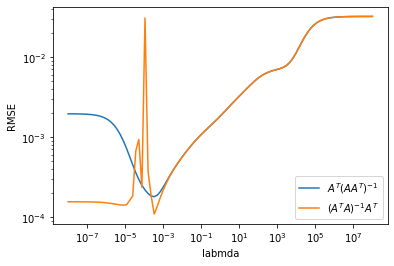

In [35]:
lmd = []
rmse1 = []
rmse2 = []
for l in np.logspace(-8, 8, num=100):

    Apinv1 = A.T @ np.linalg.inv(A @ A.T + l * np.eye(A.shape[0]))
    Apinv2 = np.linalg.inv(A.T @ A + l * np.eye(A.shape[1])) @ A.T
    x1 = Apinv1 @ b
    x2 = Apinv2 @ b
    rmse1.append(np.linalg.norm(A @ x1 - b) / b.shape[0])
    rmse2.append(np.linalg.norm(A @ x2 - b) / b.shape[0])
    lmd.append(l)


plt.plot(lmd, rmse1, label='$A^T (A A^T)^{-1}$')
plt.plot(lmd, rmse2, label='$(A^T A)^{-1} A^T$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('RMSE')
plt.xlabel('labmda')
plt.legend()


$\lambda$が小さいと値が不安定だが，これは行列式$|A^T A + \lambda I|$が非常に小さいため．

この場合には0.4から0.6程度の値が，大きすぎず小さすぎず，という範囲．

In [36]:
print(0,
        np.linalg.det(A @ A.T),
        np.linalg.det(A.T @ A))

for l in np.arange(0.0, 0.1, 0.01):
    print(l,
          np.linalg.det(A @ A.T + l * np.eye(A.shape[0])),
          np.linalg.det(A.T @ A + l * np.eye(A.shape[1])))
for l in np.arange(0.4, 0.6, 0.01):
    print(l,
          np.linalg.det(A @ A.T + l * np.eye(A.shape[0])),
          np.linalg.det(A.T @ A + l * np.eye(A.shape[1])))

0 0.0 0.0
0.0 1.7948024549286456e-264 0.0
0.01 5.10984564760502e-206 4.9765659500828914e-294
0.02 3.882459446202758e-183 6.711242048268414e-258
0.03 3.806096115916854e-167 3.6960790262831173e-234
0.04 1.4223426711837617e-154 4.350488233836062e-216
0.05 4.1919439533670185e-144 2.3587191554373747e-201
0.06 4.441654137834751e-135 7.626038306883301e-189
0.07 4.081803916447961e-127 6.189749958478008e-178
0.08 5.7042113110466e-120 3.083135085084981e-168
0.09 1.7764971378637173e-113 1.7113775962189435e-159
0.4 4.851380165055721e-16 1.4988380102700478e-33
0.41000000000000003 3.368283120127085e-14 3.084370600552604e-31
0.42000000000000004 2.1447754571687417e-12 5.670698222809611e-29
0.43000000000000005 1.2571118526314218e-10 9.3602783526676e-27
0.44000000000000006 6.805696020699345e-09 1.3935072842088326e-24
0.45000000000000007 3.414072477497004e-07 1.8791338518520796e-22
0.4600000000000001 1.5917853340855352e-05 2.3045082208323177e-20
0.4700000000000001 0.000691734909398232 2.579935198073926e-

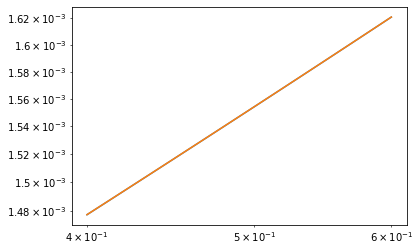

In [37]:
lmd = []
rmse1 = []
rmse2 = []
for l in np.linspace(0.4, 0.6, num=100):

    Apinv1 = A.T @ np.linalg.inv(A @ A.T + l * np.eye(A.shape[0]))
    Apinv2 = np.linalg.inv(A.T @ A + l * np.eye(A.shape[1])) @ A.T
    x1 = Apinv1 @ b
    x2 = Apinv2 @ b
    rmse1.append(np.linalg.norm(A @ x1 - b) / b.shape[0])
    rmse2.append(np.linalg.norm(A @ x2 - b) / b.shape[0])
    lmd.append(l)

plt.plot(lmd, rmse1)
plt.plot(lmd, rmse2)
plt.xscale('log')
plt.yscale('log')


拡張ラグランジュの解も求めてみる．

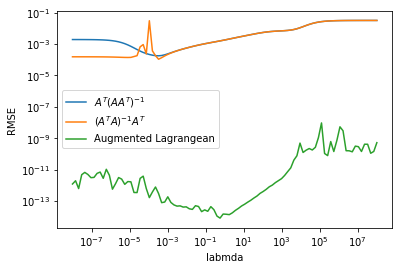

In [38]:
lmd = []
rmse1 = []
rmse2 = []
rmse3 = []
for l in np.logspace(-8, 8, num=100):

    Apinv1 = A.T @ np.linalg.inv(A @ A.T + l * np.eye(A.shape[0]))
    Apinv2 = np.linalg.inv(A.T @ A + l * np.eye(A.shape[1])) @ A.T

    Apinv3 = np.linalg.inv(l * A.T @ A + np.eye(A.shape[1])) @ A.T \
        @ np.linalg.inv( A @ np.linalg.inv(l * A.T @ A + np.eye(A.shape[1])) @ A.T )

    x1 = Apinv1 @ b
    x2 = Apinv2 @ b
    x3 = Apinv3 @ b
    rmse1.append(np.linalg.norm(A @ x1 - b) / b.shape[0])
    rmse2.append(np.linalg.norm(A @ x2 - b) / b.shape[0])
    rmse3.append(np.linalg.norm(A @ x3 - b) / b.shape[0])
    lmd.append(l)

plt.plot(lmd, rmse1, label='$A^T (A A^T)^{-1}$')
plt.plot(lmd, rmse2, label='$(A^T A)^{-1} A^T$')
plt.plot(lmd, rmse3, label='Augmented Lagrangean')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('RMSE')
plt.xlabel('labmda')
plt.legend()

# Ax=0の解

劣決定なのでAx=0の解が存在する．それを求めてみる．

まずは固有値を計算する．

In [47]:
# eig_val, eig_vec = np.linalg.eig(A.T @ A)  # こちらは一般の行列用
eig_val, eig_vec = np.linalg.eigh(A.T @ A)  # 対称行列用

固有値のプロット．数値計算誤差により，マイナスの固有値も出てしまっているが絶対値は小さいのでほぼゼロとみなせる．

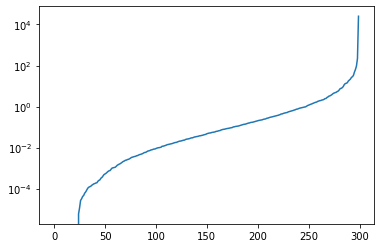

In [48]:
plt.plot(eig_val)
plt.yscale('log')

最小固有値に対応する固有ベクトルv_minで計算すると，確かにほぼゼロになっている．
（なおマイナスの固有値が出ているので，絶対値を取る）

In [50]:
i = np.argmin(np.abs(eig_val))
v_min = eig_vec[:, i]
v_min.T @ A.T @ A @ v_min, np.linalg.norm(A @ v_min), np.abs(eig_val).min()

(1.3343476e-05, 0.0036528849, 5.849082e-06)

Aの特異値分解で同様にやってみる．

In [51]:
U, W, Vtranspose = np.linalg.svd(A)
U.shape, W.shape, Vtranspose.shape

((256, 256), (256,), (300, 300))

特異値のプロット．こちらは安定している．

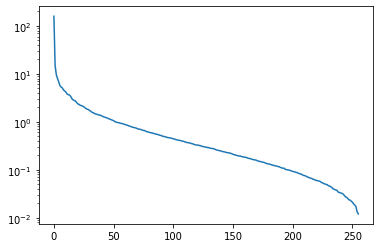

In [52]:
plt.plot(W)
plt.yscale('log')

最小特異値（つまり最小固有値）に対応する特異ベクトルv_minで計算すると，確かにほぼゼロになっている．

In [55]:
i = np.argmin(W)
v_min = Vtranspose[i]  # V^Tのi行目 = Vのi列目
v_min.T @ A.T @ A @ v_min, np.linalg.norm(A @ v_min), W.min(), W.min() ** 2

(0.00014558047, 0.012065686, 0.0120656835, 0.00014558071811773213)